### Imports

In [203]:
#!/usr/bin/env python3

from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, rand
import numdifftools as nd
import picos as pc
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import time

plt.style.use("default")

### Runtime

In [204]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [205]:
name_of_dataset = 'Angle'
#name_of_dataset = 'CShape'
#name_of_dataset = 'Sshape'

dataset = loadmat("Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

#### Mean of dataset

In [206]:
num_of_train_datasets = 4
num_of_points = len(dataset['demos'][0,0][0,0][0][0])

pos_cell_1 = np.zeros((num_of_points, num_of_train_datasets))
pos_cell_2 = np.zeros((num_of_points, num_of_train_datasets))
vel_cell_1 = np.zeros((num_of_points, num_of_train_datasets))
vel_cell_2 = np.zeros((num_of_points, num_of_train_datasets))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2]

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1)
x_train_2 = pos_cell_2.mean(axis=1)
y_train_1 = vel_cell_1.mean(axis=1)
y_train_2 = vel_cell_2.mean(axis=1)

# Defines the position and velocity measurements
x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0]

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1] 

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1)
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries
num_of_test_datasets = num_of_demos - num_of_train_datasets

# Intial starting point for the simulated trajectory using learnt model
init_condition = x_train[:, 0]

timespan = np.array([time_series[0],time_series[-1]])
t_series = np.linspace(time_series[0],time_series[-1], 1000)

#### Plot dataset (state trajectory with velocities as arrows)

C:\Users\vilde\AppData\Local\Temp\ipykernel_22004\1901655976.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


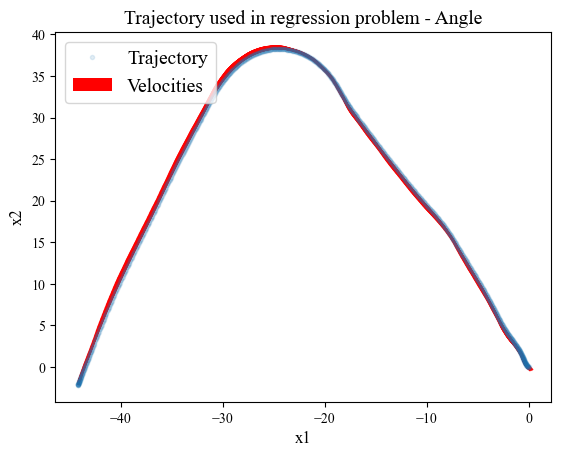

In [207]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.', alpha = 0.12)
plt.quiver(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:], color = 'red', scale = 700)
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Velocities'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_dataset.show()
#plt.savefig("../src/figures_plot/lasa_datatset.eps", format ="eps")

axes = plt.gca() #gca = get current axes, from my last plot

#### Define vector-field and axis

In [208]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1-8, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

t = 0

### Vector-valued RFF for Gaussian Separable Kernel

In [209]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, d, dim):
    psi = psi_vector(x, w, b, d)
    return np.kron(psi, np.eye(dim))

#### Psi derivative

In [210]:
def psi_derivative(x, w, b, d):
    return np.sqrt(2/d) * (-np.sin(w.T@x + b)) * w

#### Variables

In [211]:
sigma = 10
lambda_ = 0.1
num_of_constraint_points = 250
num_of_samples = 100

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi
mu = 0.0

### Random Features Vanishing on a Point Set

In [212]:
def phi_function(x, w, b, N, d, dim):
    phi = np.zeros((dim*N, dim*d))
    psi = capital_psi(x, w, b, d, dim)
    phi[dim*0] = psi[0]
    phi[dim*0+1] = psi[1]
    return phi

def capital_psi_z_function(x, w, b, d, dim, L):
    psi = capital_psi(x, w, b, d, dim)
    return L.T @ psi.T

def capital_phi_z_function(x, w, b, N, d, dim, L):
    phi = np.zeros((dim*N, dim*d))
    for i in range(N):
        psi = capital_psi_z_function(x[:,i], w, b, d, dim, L)
        phi[dim*i] = psi.T[0]
        phi[dim*i+1] = psi.T[1]
    return phi

#### Finding L

In [213]:
x_vanish = x_train[:,-1]
num_of_vanish_points = np.size(x_vanish[0])

capital_phi_z = phi_function(x_vanish, w, b, num_of_vanish_points, num_of_samples, dim_of_function)

# Calculate P_Psi = LL^T as done by Sindhwani
capital_phi_z = capital_phi_z.T
P_Psi = capital_phi_z @ np.linalg.inv(capital_phi_z.T @ capital_phi_z)@capital_phi_z.T
P_Psi = np.eye(P_Psi[0].size) - P_Psi

# Fix symmetry of matrix and buffer against numerical noise
P_Psi = (P_Psi + P_Psi.T) / 2 + (np.eye(P_Psi[0].size)*1e-12)

L_ = np.linalg.cholesky(P_Psi)
#P_Psi_L = L @ L.T

#### Jacobian function

In [214]:
def psi_jacobi(x, w, b, d, dim, L):
    psi_vector = np.zeros(d)
    for i in range(d):
        psi_vector[i] = np.cos(w[:, i].T@x + b[:, i])
    psi = np.sqrt(2/d) * np.kron(psi_vector, np.eye(dim))
    psi_L = L.T @ psi.T
    return psi_L.T

#### Alpha without constraint for vanish point

In [215]:
def alpha_approx_z(x, y, w, b, dim, d, lam, N, L):
    phi_ = capital_phi_z_function(x, w, b, N, d, dim, L)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    d_param = pc.Constant('d', d)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_param', (d_param*dim_param, 1))
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

In [216]:
alpha_z = alpha_approx_z(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, L_)

C:\Users\vilde\AppData\Local\Temp\ipykernel_22004\346863830.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel_closed_form.show()


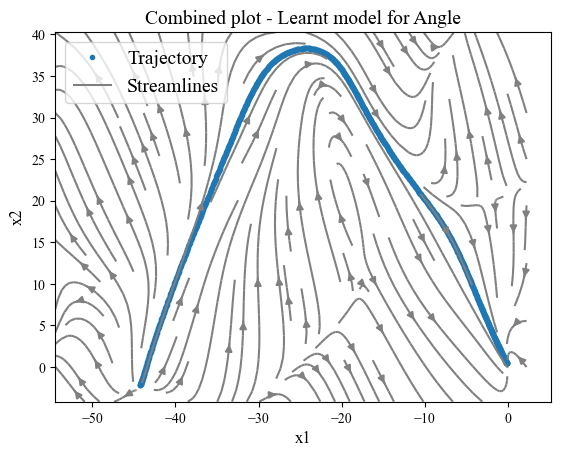

In [217]:
# Create callable function for learnt dynamics (straight from working note)
def learnt_model_vanish(t, x):
    func = capital_psi_z_function(x, w, b, num_of_samples, dim_of_function, L_).T @ alpha_z
    return func

data_series = solve_ivp(learnt_model_vanish, timespan, init_condition, t_eval = t_series).y

u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    Y_prime = learnt_model_vanish(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

fig_learntmodel_closed_form = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel_closed_form.show()

#### Alpha with analytical jacobian for vanish point

In [218]:
def alpha_approx_with_constraint_z(x, y, w, b, dim, d, lam, N, mu, constraint_points, L):
    phi_ = capital_phi_z_function(x, w, b, N, d, dim, L)
    mu = mu * np.eye(dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    d_param = pc.Constant('d', d)
    mu_param = pc.Constant('mu', mu)
    constraint_points_param = pc.Constant('constraint_points', constraint_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (d_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points_param):
        constraint_index = i*np.int64(np.floor(len(x[0])/constraint_points))
        x_i = x[:, constraint_index]
        gradient = np.zeros(dim)
        for j in range(d):
            index = 2*j
            psi_derivative_param = pc.Constant('psi_derivative', psi_derivative(x_i, w[:, j], b[:, j], d))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

In [219]:
alpha_approx_z_with_constraint = alpha_approx_with_constraint_z(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_constraint_points, L_)

C:\Users\vilde\AppData\Local\Temp\ipykernel_22004\806766299.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel_numerical.show()


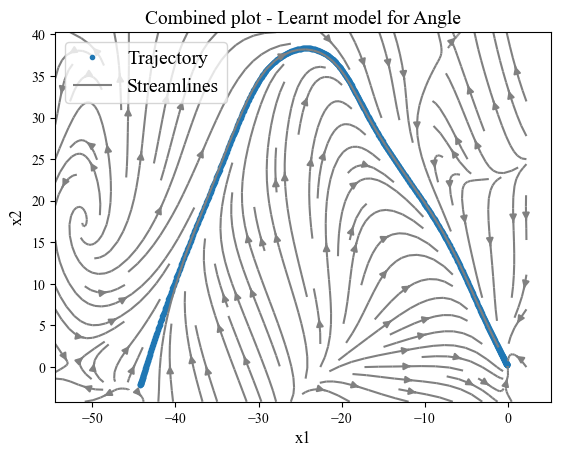

In [220]:
# Create callable function for learnt dynamics (straight from working note)
def learnt_model_vanish_with_constraint(t, x):
    func = capital_psi_z_function(x, w, b, num_of_samples, dim_of_function, L_).T @ alpha_approx_z_with_constraint
    return func

data_series_numerical = solve_ivp(learnt_model_vanish_with_constraint, timespan, init_condition, t_eval = t_series).y

u_learnt_numerical = np.zeros(X1.shape)
v_learnt_numerical = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    Y_prime_numerical = learnt_model_vanish_with_constraint(t, np.array([value, X2[i, j]]))
    u_learnt_numerical[i,j] = Y_prime_numerical[0]
    v_learnt_numerical[i,j] = Y_prime_numerical[1]

fig_learntmodel_numerical = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series_numerical[0, :], data_series_numerical[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt_numerical, v_learnt_numerical, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel_numerical.show()

#### Finding alpha using finite difference

In [221]:
def alpha_approx_with_constraint_fdm(x, y, w, b, dim, d, lam, N, mu, constraint_points, L):
    phi_ = capital_phi_z_function(x, w, b, N, d, dim, L)
    mu = mu*np.eye(dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    d_param = pc.Constant('d', d)
    mu_param = pc.Constant('mu', mu)
    constraint_points_param = pc.Constant('constraint_points', constraint_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (d_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points_param):
        constraint_index = i*np.int64(np.floor(len(x[0])/constraint_points))
        x_i = x[:, constraint_index]
        gradient = np.zeros(dim)
        jacobi_function = nd.Jacobian(psi_jacobi)
        jacobi_ = jacobi_function(x_i, w, b, d, dim, L)
        jacobi_param = pc.Constant('jacobi', [0, 0], (2, 2))
        for j in range(len(alpha_var)):
            jacobi_param += pc.Constant(jacobi_[:, :, j]) * alpha_var[j]
        gradient = gradient + 0.5 * (jacobi_param + jacobi_param.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

In [222]:
alpha_fdm = alpha_approx_with_constraint_fdm(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_constraint_points, L_)

C:\Users\vilde\AppData\Local\Temp\ipykernel_22004\1720158653.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel_fdm.show()


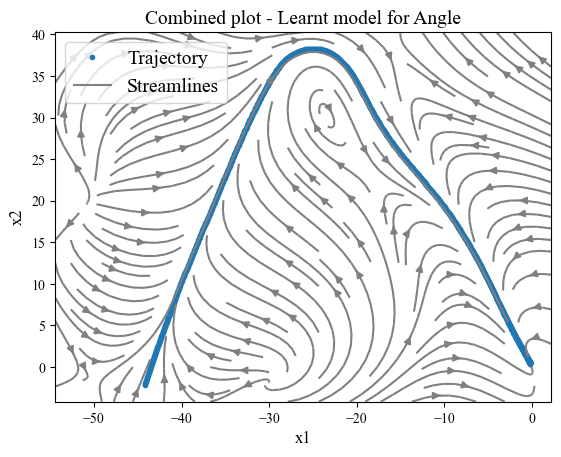

In [223]:
# Create callable function for learnt dynamics (straight from working note)
def learnt_model_fdm(t, x):
    func = capital_psi_z_function(x, w, b, num_of_samples, dim_of_function, L_).T @ alpha_fdm
    return func

data_series_fdm = solve_ivp(learnt_model_fdm, timespan, init_condition, t_eval = t_series).y

u_learnt_fdm = np.zeros(X1.shape)
v_learnt_fdm = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    Y_prime_fdm = learnt_model_fdm(t, np.array([value, X2[i, j]]))
    u_learnt_fdm[i,j] = Y_prime_fdm[0]
    v_learnt_fdm[i,j] = Y_prime_fdm[1]

fig_learntmodel_fdm = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series_fdm[0, :], data_series_fdm[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt_fdm, v_learnt_fdm, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel_fdm.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps") 

#### Reproduction Accuracy

C:\Users\vilde\AppData\Local\Temp\ipykernel_22004\1573225738.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel_fdm.show()


1.0116560670387436


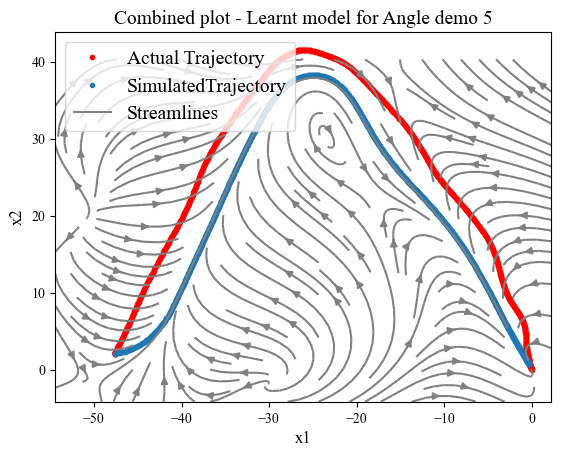

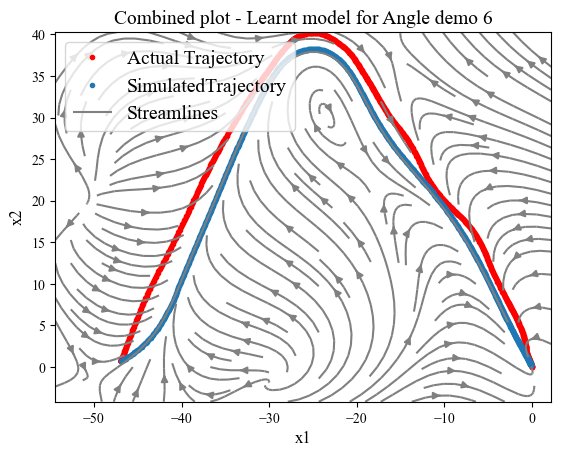

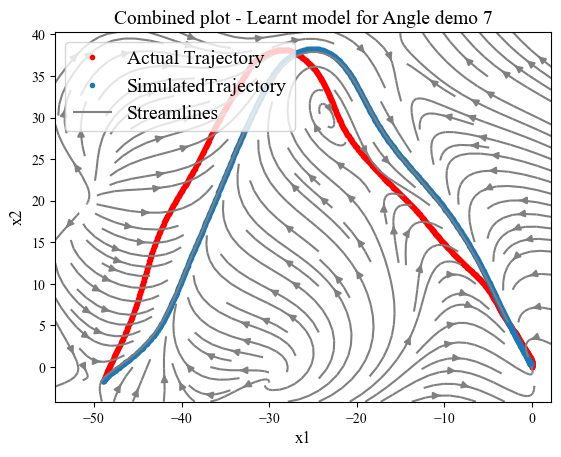

In [224]:
trajectory_error = np.zeros(num_of_test_datasets)

for i in range(num_of_test_datasets):
    demo_pos = num_of_train_datasets + i
    actual_trajectory = dataset['demos'][0, demo_pos][0, 0][0]
    actual_time = dataset['demos'][0, demo_pos][0, 0][1]
    timespan = np.array([actual_time[:, 0], actual_time[:, -1]])
    initial_condition = actual_trajectory[:, 0]
    simulated_trajectory = solve_ivp(learnt_model_fdm, timespan, initial_condition, t_eval = actual_time[0]).y

    error = np.mean(np.linalg.norm(actual_trajectory - simulated_trajectory, ord=2, axis=0) / actual_time[:, -1])
    trajectory_error[i] = error

    demo_number = demo_pos+1
    fig_learntmodel_fdm = plt.figure(i+num_of_train_datasets)
    plt.title('Combined plot - Learnt model for ' + name_of_dataset + ' demo ' + str(demo_number), fontsize=14)
    plt.plot(actual_trajectory[0, :], actual_trajectory[1, :], '.', linewidth=0.1, color = 'r')
    plt.plot(simulated_trajectory[0, :], simulated_trajectory[1, :], '.', linewidth=0.1)
    plt.streamplot(X1, X2, u_learnt_fdm, v_learnt_fdm, density = 1.1, color ='gray')
    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.legend(['Actual Trajectory', 'SimulatedTrajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
    fig_learntmodel_fdm.show()
    #plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps") 


trajectory_mean_error = np.mean(trajectory_error)
print(np.mean(trajectory_error))